In [ ]:
import pandas as pd
import duckdb
import os
import glob
import sqlite3
import shutil
import matplotlib.pyplot as plt
#duckdb.execute("INSTALL sqlite;LOAD sqlite;")

: 

# Main Tables Creation

## Main One: All records

The process of download original records from rainfall data on IDEAM open network was the longest one. For this task, we split in order to download at least each one of us 10 station per departamento (Colombia admin level 1). At the end, we created a whole dataframe and check if there are duplicated rows given some data issues (e.g. two of us download the exact same data or someone copy and paste data twice in different folder)

In [ ]:
# Define the directory containing CSV files
csv_directory = r'C:\Users\alexa\Desktop\Appli_AlexanderMontalvo\Data\Original Data\Stations'

# Find all CSV files in the directory and subdirectories
csv_files = glob.glob(os.path.join(csv_directory, '**', '*.csv'), recursive=True)

# List to hold individual DataFrames
orig_downloads = []

# Iterate over the CSV files and read them into DataFrames
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    orig_downloads.append(df)

# Concatenate all DataFrames into a single DataFrame
final_combined_df = pd.concat(orig_downloads, ignore_index=True)

# Convert Fecha, FechaInstalacion, and FechaSuspension to datetime
final_combined_df['Fecha'] = pd.to_datetime(final_combined_df['Fecha'], errors='coerce')
final_combined_df['FechaInstalacion'] = pd.to_datetime(final_combined_df['FechaInstalacion'], errors='coerce')
final_combined_df['FechaSuspension'] = pd.to_datetime(final_combined_df['FechaSuspension'], errors='coerce')

# Extract month and year from Fecha
final_combined_df['Month'] = final_combined_df['Fecha'].dt.month
final_combined_df['Year'] = final_combined_df['Fecha'].dt.year

# Read and merge ONI data: Data Handling, this output comes from ONI Data subsection below
oni_df = pd.read_csv(r"C:\Users\alexa\Desktop\Appli_AlexanderMontalvo\Data\Data Processing\CSV EXCELS\ONI_Data_Cleaned_longformat.csv")
final_combined_df = final_combined_df.merge(oni_df[['Year', 'Month', 'Phase', 'Intensity']], on=['Year', 'Month'], how='left')

# Find duplicate rows (if there are)
duplicate_rows = final_combined_df[final_combined_df.duplicated()]

# Count the number of duplicate rows
num_duplicate_rows = duplicate_rows.shape[0]

# Remove duplicate rows
final_combined_df = final_combined_df.drop_duplicates()

final_combined_df.sample(3)



C:\Users\alexa\AppData\Local\Temp\ipykernel_26680\2925335553.py:20: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  final_combined_df['FechaInstalacion'] = pd.to_datetime(final_combined_df['FechaInstalacion'], errors='coerce')
C:\Users\alexa\AppData\Local\Temp\ipykernel_26680\2925335553.py:21: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  final_combined_df['FechaSuspension'] = pd.to_datetime(final_combined_df['FechaSuspension'], errors='coerce')


,CodigoEstacion,NombreEstacion,Latitud,Longitud,Altitud,Categoria,Entidad,AreaOperativa,Departamento,Municipio,...,Frecuencia,Fecha,Valor,Grado,Calificador,NivelAprobacion,Month,Year,Phase,Intensity
86384,35230030,TABLON DE TAMARA [35230030],5.747194,-72.103000,350,Pluviográfica,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...,Area Operativa 06 - Boyacá-Casanare-Vichada,Casanare,Támara,...,Mensual,2019-04-01,427.9,50,NaN,900,4.0,2019.0,El Niño,Weak
173630,21230120,LA BELLEZA [21230120],4.985389,-74.581111,1200,Pluviométrica,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...,Area Operativa 11 - Cundinamarca-Amazonas,Cundinamarca,Chaguaní,...,Mensual,1990-10-01,308.6,50,NaN,900,10.0,1990.0,Neutral,Neutral
59839,25021610,AGRADO EL [25021610],9.685667,-74.504861,100,Pluviométrica,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...,Area Operativa 05 - Magdalena-Cesar-Guajira-Sa...,Magdalena,Plato,...,Mensual,2021-03-01,35.0,50,NaN,900,3.0,2021.0,La Niña,Weak


## Just Coordinates

In [14]:
just_coordinates_df=final_combined_df[['CodigoEstacion', 'NombreEstacion', 'Latitud', 'Longitud', 'Altitud','Departamento', 'Municipio']]
just_coordinates_df=just_coordinates_df.drop_duplicates(subset='CodigoEstacion')
just_coordinates_df

,CodigoEstacion,NombreEstacion,Latitud,Longitud,Altitud,Departamento,Municipio
0,26180160,ABEJORRAL [26180160],5.785972,-75.430417,2170,Antioquia,Abejorral
522,26230240,ABERTURA LA [26230240],6.900194,-75.704833,2550,Antioquia,San Andrés
844,11110020,ABRIAQUI [11110020],6.642500,-76.075000,1920,Antioquia,Abriaquí
1371,23085270,AEROPUERTO J.M. CORDOVA - AUT [23085270],6.168611,-75.426111,2131,Antioquia,Rionegro
1898,12015070,AEROPUERTO LOS CEDROS [12015070],7.816389,-76.717889,41,Antioquia,Carepa
...,...,...,...,...,...,...,...
260320,42080010,PUERTO TOLIMA [42080010],1.198250,-69.910861,175,Vaupes,Mitú
260784,42080020,QUERARI [42080020],1.073944,-69.843944,172,Vaupes,Mitú
261239,42070010,SAN ANTONIO [42070010],1.210000,-70.710000,185,Vaupes,Mitú
261668,42070030,VILLAFATIMA [42070030],0.993722,-69.910694,175,Vaupes,Mitú


## Missing records summary table

In here we calculate the percentage of missing monthly record per each queried station. We do this by identified which one was the first and the last date with records of each station and then, that difference (in month) is the new column called *'Exp Records'*. After that, other columns is created *'Record Count'* which is actually how many record has each station. 

In [18]:
# Calculate the number of records per CodigoEstacion
records_per_codigo_estacion = final_combined_df.groupby('CodigoEstacion')['Valor'].count().reset_index(name='RecordCount')



# Define the function to calculate ExpRecords
def calculate_exp_records(row):
    # Ensure Fecha and FechaInstalacion are datetime objects
    fecha = pd.to_datetime(row['Fecha'], errors='coerce')
    fecha_instalacion = pd.to_datetime(row['FechaInstalacion'], errors='coerce')
    
    # Calculate the difference in years and months
    diff_years = fecha.year - fecha_instalacion.year
    diff_months = fecha.month - fecha_instalacion.month
    
    # Convert the difference to total months
    exp_records = diff_years * 12 + diff_months
    
    return exp_records

# Sort the DataFrame by CodigoEstacion and Fecha to ensure the latest records are at the top
sorted_df = final_combined_df.sort_values(by=['CodigoEstacion', 'Fecha'], ascending=[True, False])

# Drop duplicates based on CodigoEstacion, keeping only the last updated record
last_updated_df = sorted_df.drop_duplicates(subset='CodigoEstacion', keep='first')
# Calculate the minimum Fecha for each CodigoEstacion
fecha_min_df = final_combined_df.groupby('CodigoEstacion')['Fecha'].min().reset_index()
fecha_min_df.rename(columns={'Fecha': 'FirstRecord'}, inplace=True)
# Assuming concatenated_df is already defined and contains the necessary data
# Apply the function to each row in the DataFrame
last_updated_df['ExpRecords'] = last_updated_df.apply(calculate_exp_records, axis=1)




missing_records_df = pd.merge(last_updated_df, records_per_codigo_estacion, on='CodigoEstacion', how='left')
missing_records_df = pd.merge(missing_records_df, fecha_min_df, on='CodigoEstacion', how='left')
missing_records_df=missing_records_df[['CodigoEstacion', 'NombreEstacion', 'FechaInstalacion','FirstRecord','Fecha', 
                                       'ExpRecords','RecordCount','Departamento','Latitud','Longitud','Altitud']]
missing_records_df.columns=['CodigoEstacion', 'Nombre', 'FechaInstalacion','FirstRecord','LastRecord', 'ExpRecords','RecordCount',
                            'Departamento','Latitud','Longitud','Altitud']
missing_records_df['MissingRecords'] = missing_records_df['ExpRecords'] - missing_records_df['RecordCount']

missing_records_df.sort_values(by='MissingRecords', ascending=False).tail(3)


C:\Users\alexa\AppData\Local\Temp\ipykernel_26680\4274128423.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_updated_df['ExpRecords'] = last_updated_df.apply(calculate_exp_records, axis=1)


,CodigoEstacion,Nombre,FechaInstalacion,FirstRecord,LastRecord,ExpRecords,RecordCount,Departamento,Latitud,Longitud,Altitud,MissingRecords
24,13070290,TAMPA [13070290],1978-05-15,1986-09-01,2014-11-01,438.0,308,Cordoba,8.624722,-75.767222,20,130.0
297,29040020,MONTEBELLO [29040020],1985-12-15,1990-01-01,2024-09-01,465.0,408,Atlantico,10.708500,-74.907833,100,57.0
1,11020010,CARMEN DE ATRATO [11020010],1958-10-15,1980-01-01,2023-12-01,782.0,528,Choco,5.908528,-76.142083,1850,254.0


## Plain Code, Date, Value table

In [19]:
just_records_df=final_combined_df[['CodigoEstacion', 'NombreEstacion','Fecha','Year','Month','Valor']]

## Descript Stats: Plain, by month, by year, and by ENSO Phase

In [30]:
# Group by CodigoEstacion and calculate descriptive statistics
descriptive_stats_by_estacion = just_records_df.groupby('CodigoEstacion').agg(
    mean=('Valor', 'mean'),
    median=('Valor', 'median'),
    pct_25=('Valor', lambda x: x.quantile(0.25)),
    pct_75=('Valor', lambda x: x.quantile(0.75)),
    max=('Valor', 'max'),
    min=('Valor', 'min'),
    std=('Valor', 'std')
).reset_index()

descriptive_stats_by_yearestacion = just_records_df.groupby(['Year', 'CodigoEstacion']).agg(
    mean=('Valor', 'mean'),
    median=('Valor', 'median'),
    pct_25=('Valor', lambda x: x.quantile(0.25)),
    pct_75=('Valor', lambda x: x.quantile(0.75)),
    max=('Valor', 'max'),
    min=('Valor', 'min'),
    std=('Valor', 'std')
).reset_index()

descriptive_stats_by_monthestacion = just_records_df.groupby(['Month', 'CodigoEstacion']).agg(
    mean=('Valor', 'mean'),
    median=('Valor', 'median'),
    pct_25=('Valor', lambda x: x.quantile(0.25)),
    pct_75=('Valor', lambda x: x.quantile(0.75)),
    max=('Valor', 'max'),
    min=('Valor', 'min'),
    std=('Valor', 'std')
).reset_index()


# Convert to long format
descriptive_stats_by_estacion_long = descriptive_stats_by_estacion.melt(id_vars=['CodigoEstacion'], 
                                                                        var_name='StatType', 
                                                                        value_name='Value')

descriptive_stats_by_yearestacion_long = descriptive_stats_by_yearestacion.melt(id_vars=['Year', 'CodigoEstacion'], 
                                                                                var_name='StatType', 
                                                                                value_name='Value')

descriptive_stats_by_monthestacion_long = descriptive_stats_by_monthestacion.melt(id_vars=['Month', 'CodigoEstacion'], 
                                                                                  var_name='StatType', 
                                                                                  value_name='Value')



In [31]:
# ONI Analysis
# Calculate the mean value for each CodigoEstacion, Month, and Phase
mean_values = final_combined_df.groupby(['CodigoEstacion','Phase'])['Valor'].mean().reset_index()
mean_values.rename(columns={'Valor': 'MeanValue'}, inplace=True)

# Merge the mean values back to final_combined_df
final_combined_df = final_combined_df.merge(mean_values, on=['CodigoEstacion', 'Phase'], how='left')

# Calculate the anomaly by subtracting the mean value from the actual value
final_combined_df['Anomaly'] = final_combined_df['Valor'] - final_combined_df['MeanValue']

# Select relevant columns for the anomalies DataFrame
anomalies_df = final_combined_df[['CodigoEstacion', 'Phase', 'Anomaly']]
anomalies_df=anomalies_df.groupby(['CodigoEstacion','Phase'])['Anomaly'].median().reset_index().sort_values('Anomaly',ascending=True)
print(len(anomalies_df))

# Select the relevant columns from just_coordinates_df
just_coordinates_selected = just_coordinates_df[['CodigoEstacion', 'Latitud', 'Longitud', 'Altitud', 'Departamento', 'Municipio']]
# Merge the DataFrames based on the CodigoEstacion column
anomalies_df_coords = pd.merge(anomalies_df, just_coordinates_selected, on='CodigoEstacion', how='left')

anomalies_df_coords_lanina = anomalies_df_coords[anomalies_df_coords['Phase'] == 'La Niña']
anomalies_df_coords_elnino = anomalies_df_coords[anomalies_df_coords['Phase'] == 'El Niño']

anomalies_df_coords_elnino.sort_values(by='CodigoEstacion', ascending=False).sample(4)



1409


,CodigoEstacion,Phase,Anomaly,Latitud,Longitud,Altitud,Departamento,Municipio
39,24050160,El Niño,-61.913043,6.916667,-73.450000,960,Santander,San Vicente De Chucurí
336,35070550,El Niño,-26.592727,5.056611,-73.426917,1830,Boyacá,Tenza
292,16055040,El Niño,-28.288489,8.087222,-73.223056,1430,Norte De Santander,Ábrego
196,52090020,El Niño,-34.398214,2.190361,-78.416389,40,Nariño,Roberto Payán (San José)


## ONI Data
This script portion, generated the *ONI_Data_Cleaned_longformat.csv* that was refereced before. Here we index base on datetime the original data and classified the intensity of the ENSO phase (if exist). Finally we generated the main output in a long format that was read it in the first analysis where *final_combined_df is generated*

In [ ]:
oni_df=pd.read_csv(r"C:\Users\alexa\Desktop\Appli_AlexanderMontalvo\Data\Original Data\ONI_Data.csv")
# Reshape the dataset into a long format
oni_long_df = oni_df.melt(id_vars=["Year"], 
                          var_name="Season", 
                          value_name="Value")

# Define thresholds for phases and intensities
def classify_enso_phase_and_intensity(value):
    if value >= 0.5:
        phase = 'El Niño'
        if 0.5 <= value <= 0.9:
            intensity = 'Weak'
        elif 1.0 <= value <= 1.4:
            intensity = 'Moderate'
        else:
            intensity = 'Strong'
    elif value <= -0.5:
        phase = 'La Niña'
        if -0.9 <= value <= -0.5:
            intensity = 'Weak'
        elif -1.4 <= value <= -1.0:
            intensity = 'Moderate'
        else:
            intensity = 'Strong'
    else:
        phase = 'Neutral'
        intensity = 'Neutral'
    return phase, intensity

# Apply classification to the dataframe
oni_long_df[['Phase', 'Intensity']] = oni_long_df['Value'].apply(lambda x: pd.Series(classify_enso_phase_and_intensity(x)))

# Map each season to the corresponding month (taking the 2nd month in each 3-month window)
season_to_month = {
    "DJF": 1,  # January
    "JFM": 2,  # February
    "FMA": 3,  # March
    "MAM": 4,  # April
    "AMJ": 5,  # May
    "MJJ": 6,  # June
    "JJA": 7,  # July
    "JAS": 8,  # August
    "ASO": 9,  # September
    "SON": 10, # October
    "OND": 11, # November
    "NDJ": 12  # December
}

# Add a column for Month
oni_long_df['Month'] = oni_long_df['Season'].map(season_to_month)

# Reorganize columns
oni_long_df = oni_long_df[['Year', 'Month', 'Value', 'Phase', 'Intensity']]
oni_long_df.sample(3)


# # Save the cleaned and structured data to a new CSV file
# output_file_path = r"C:\Users\alexa\Desktop\Appli_AlexanderMontalvo\Data\Data Processing\CSV EXCELS\ONI_Data_Cleaned_longformat.csv"
# oni_long_df.to_csv(output_file_path, index=False)




,Year,Month,Value,Phase,Intensity
355,2005,5,0.3,Neutral,Neutral
170,1970,3,0.3,Neutral,Neutral
726,2001,10,-0.3,Neutral,Neutral


# Exports CSV files, final tables


In [ ]:
output_file_path = r"C:\Users\alexa\Desktop\Appli_AlexanderMontalvo\Data\Data Processing\CSV EXCELS"


# Ensure the output directory exists
os.makedirs(output_file_path, exist_ok=True)

# # Save each DataFrame to a CSV file
# final_combined_df.to_csv(os.path.join(output_file_path, 'final_combined_df.csv'), index=False)
# just_coordinates_df.to_csv(os.path.join(output_file_path, 'just_coordinates_df.csv'), index=False)
# missing_records_df.to_csv(os.path.join(output_file_path, 'missing_records_df.csv'), index=False)
# descriptive_stats_by_estacion_long.to_csv(os.path.join(output_file_path, 'descriptive_stats_by_estacion.csv'), index=False)
# descriptive_stats_by_yearestacion_long.to_csv(os.path.join(output_file_path, 'descriptive_stats_by_yearestacion_.csv'), index=False)
# descriptive_stats_by_monthestacion_long.to_csv(os.path.join(output_file_path, 'descriptive_stats_by_monthestacion.csv'), index=False)
# #anomalies_df.to_csv(os.path.join(output_file_path, 'anomalies_df.csv'), index=False)
#anomalies_df_coords_lanina.to_csv(os.path.join(output_file_path, 'anomalies_df_lanina.csv'), index=False)
#anomalies_df_coords_elnino.to_csv(os.path.join(output_file_path, 'anomalies_df_elnino.csv'), index=False)

print("DataFrames have been saved to CSV files.")


DataFrames have been saved to CSV files.


In [55]:
# Calculate the number of records per CodigoEstacion
records_per_codigo_estacion = concatenated_df.groupby('CodigoEstacion')['Valor'].count().reset_index(name='RecordCount')



# Define the function to calculate ExpRecords
def calculate_exp_records(row):
    # Ensure Fecha and FechaInstalacion are datetime objects
    fecha = pd.to_datetime(row['Fecha'], errors='coerce')
    fecha_instalacion = pd.to_datetime(row['FechaInstalacion'], errors='coerce')
    
    # Calculate the difference in years and months
    diff_years = fecha.year - fecha_instalacion.year
    diff_months = fecha.month - fecha_instalacion.month
    
    # Convert the difference to total months
    exp_records = diff_years * 12 + diff_months
    
    return exp_records

# Assuming concatenated_df is already defined and contains the necessary data
# Convert Fecha and FechaInstalacion to datetime if they are not already
concatenated_df['Fecha'] = pd.to_datetime(concatenated_df['Fecha'], errors='coerce')
concatenated_df['FechaInstalacion'] = pd.to_datetime(concatenated_df['FechaInstalacion'], errors='coerce')

# Sort the DataFrame by CodigoEstacion and Fecha to ensure the latest records are at the top
sorted_df = concatenated_df.sort_values(by=['CodigoEstacion', 'Fecha'], ascending=[True, False])

# Drop duplicates based on CodigoEstacion, keeping only the last updated record
last_updated_df = sorted_df.drop_duplicates(subset='CodigoEstacion', keep='first')

# Assuming concatenated_df is already defined and contains the necessary data
# Apply the function to each row in the DataFrame
last_updated_df['ExpRecords'] = last_updated_df.apply(calculate_exp_records, axis=1)

last_updated_df[['CodigoEstacion', 'NombreEstacion','FechaInstalacion', 'FechaSuspension','Fecha','ExpRecords']]

missing_records_df = pd.merge(last_updated_df, records_per_codigo_estacion, on='CodigoEstacion', how='left')
missing_records_df[['CodigoEstacion', 'NombreEstacion', 'Fecha','FechaInstalacion','RecordCount', 'ExpRecords','Departamento']]

C:\Users\alexa\AppData\Local\Temp\ipykernel_21392\4256492155.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_updated_df['ExpRecords'] = last_updated_df.apply(calculate_exp_records, axis=1)


,CodigoEstacion,NombreEstacion,Fecha,FechaInstalacion,RecordCount,ExpRecords,Departamento
0,11010010,VUELTA LA [11010010],2023-12-01,1943-01-15,7875,971,Choco
1,11020010,CARMEN DE ATRATO [11020010],2023-12-01,1958-10-15,7920,782,Choco
2,11020050,PINON EL [11020050],2023-12-01,1958-10-15,7785,782,Choco
3,11030030,MANAGRU [11030030],2022-08-01,1977-02-15,1266,546,Choco
4,11030040,PAIMADO [11030040],2024-06-01,1977-02-15,1800,568,Choco
...,...,...,...,...,...,...,...
402,56010030,CUPICA [56010030],2024-08-01,1997-10-15,1860,322,Choco
403,56010050,ARUSI [56010050],2024-08-01,2010-03-01,1032,173,Choco
404,1506000111,SANTA ISABEL [1506000111],2024-03-01,2018-04-21,426,71,La Guajira
405,2401500040,CUCUNUBA [2401500040],2023-12-01,2018-03-13,7860,69,Cundinamarca


In [46]:
last_updated_df[['Fecha','FechaInstalacion','ExpRecords']]

,Fecha,FechaInstalacion,ExpRecords
39538,2023-12-01,1943-01-15,971
36962,2023-12-01,1958-10-15,782
38001,2023-12-01,1958-10-15,782
1330258,2022-08-01,1977-02-15,546
1330558,2024-06-01,1977-02-15,568
...,...,...,...
1329764,2024-08-01,1997-10-15,322
1329454,2024-08-01,2010-03-01,173
1349327,2024-03-01,2018-04-21,71
45971,2023-12-01,2018-03-13,69


# New tables analysis

In [11]:
anomalies_df=pd.read_csv(r"C:\Users\alexa\Documents\PERSONAL PROJECTS\Colombia Rainfall\Final Tables\anomalies_df.csv")
just_coordinates_df=pd.read_csv(r"C:\Users\alexa\Documents\PERSONAL PROJECTS\Colombia Rainfall\Final Tables\just_coordinates_df.csv")


# Select the relevant columns from just_coordinates_df
just_coordinates_selected = just_coordinates_df[['CodigoEstacion', 'Latitud', 'Longitud', 'Altitud', 'Departamento', 'Municipio']]
# Merge the DataFrames based on the CodigoEstacion column
anomalies_df_coords = pd.merge(anomalies_df, just_coordinates_selected, on='CodigoEstacion', how='left')
# Save the merged DataFrame to a new CSV file
anomalies_df_coords = anomalies_df_coords.groupby(['CodigoEstacion', 'Phase'])['Anomaly'].median().reset_index()
anomalies_df_coords.to_csv(r'C:\Users\alexa\Downloads\FInalData\anomalies_df_coords.csv', index=False)

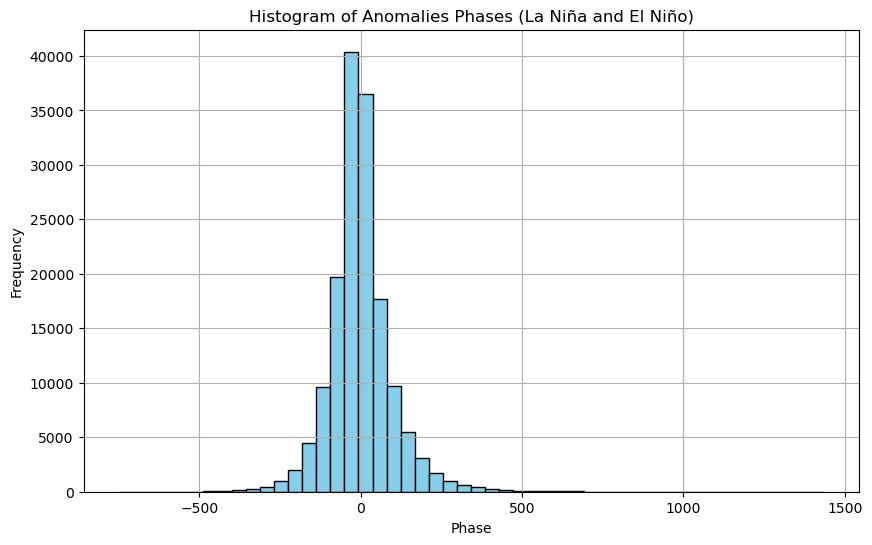

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming anomalies_df is already defined and contains the 'Phase' column

# Filter the DataFrame for 'La Niña' or 'El Niño' phases
filtered_df = anomalies_df[anomalies_df['Phase'].isin(['La Nina', 'El Nino'])]

# Create a histogram of the 'Phase' values
plt.figure(figsize=(10, 6))
filtered_df['Anomaly'].hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Anomalies Phases (La Niña and El Niño)')
plt.xlabel('Phase')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [7]:
filtered_df

,Month,CodigoEstacion,Phase,Anomaly


In [34]:
# Load the missing records DataFrame
#missing_records_df = pd.read_excel(r"C:\Users\alexa\Documents\PERSONAL PROJECTS\Colombia Rainfall\Final Tables\missing_records_df.xlsx")
allraw_records=pd.read_csv(r'C:\Users\alexa\Documents\PERSONAL PROJECTS\Colombia Rainfall\Final Tables\final_combined_df.csv')
# Assuming allraw_records is your DataFrame
# Ensure the 'Fecha' column is in datetime format
allraw_records['Fecha'] = pd.to_datetime(allraw_records['Fecha'])

# Group by 'CodigoEstacion' and aggregate the required information
missing_records_df = allraw_records.groupby('CodigoEstacion').agg(
    count=('Fecha', 'size'),
    first_date=('Fecha', 'min'),
    last_date=('Fecha', 'max'),
    longitud=('Longitud', 'first'),
    latitud=('Latitud', 'first'),
    Departamento=('Departamento', 'first'),
    Municipio=('Municipio', 'first')
).reset_index()

# Ensure the 'FirstRecord' and 'LastRecord' columns are in datetime format
missing_records_df['first_date'] = pd.to_datetime(missing_records_df['first_date'])
missing_records_df['last_date'] = pd.to_datetime(missing_records_df['last_date'])

# Calculate the number of months between 'FirstRecord' and 'LastRecord'
missing_records_df['Expected Records'] = missing_records_df.apply(
    lambda row: (row['last_date'].year - row['first_date'].year) * 12 + row['last_date'].month - row['first_date'].month,
    axis=1
)

# Convert 'count' and 'Expected Records' to integers
missing_records_df['count'] = missing_records_df['count'].astype(int)


# Calculate the percentage of missing records
missing_records_df['missing_recordspct'] = 100 - (missing_records_df['count'] / missing_records_df['Expected Records']) * 100
missing_records_df['missing_recordspct'] = missing_records_df['missing_recordspct'].apply(lambda x: 0 if x < 0 else x)

# Group by 'Departamento' and count the missing records
missing_records_df_bydpto = missing_records_df.groupby('Departamento')[['Expected Records', 'count']].sum().reset_index()

# Calculate the percentage of missing records by 'Departamento'
missing_records_df_bydpto['missing_pct'] = 100 - ((missing_records_df_bydpto['count'] / missing_records_df_bydpto['Expected Records']) * 100)

# Round 'missing_pct' to one decimal place
missing_records_df_bydpto['missing_pct'] = missing_records_df_bydpto['missing_pct'].round(1)
missing_records_df_bydpto['missing_pct'] = missing_records_df_bydpto['missing_pct'].apply(lambda x: 0 if x < 0 else x)

# Display the DataFrame
missing_records_df_bydpto.to_csv(r'C:\Users\alexa\Documents\PERSONAL PROJECTS\Colombia Rainfall\Final Tables\missing_Recordsbydpto.csv', index=False)

C:\Users\alexa\AppData\Local\Temp\ipykernel_44656\1677342076.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  allraw_records=pd.read_csv(r'C:\Users\alexa\Documents\PERSONAL PROJECTS\Colombia Rainfall\Final Tables\final_combined_df.csv')


In [ ]:
# Calculate the percentage of missing records
missing_records_df['missing_recordspct'] = 100 - (missing_records_df['Record Count'] / missing_records_df['Expected Record'])*100

# Set the percentage to 0 if it is less than 1%
missing_records_df['missing_recordspct'] = missing_records_df['missing_recordspct']
missing_records_df.drop(columns=[ 'Missing (%)'],inplace=True)

missing_records_df

,Expected Record,Record Count
Departamento,,
Amazonas,8989.4304,12368
Antioquia,4066.0848,4253
Arauca,3508.4192,3404
"Archipielago De San Andres, Providencia Y Santa Catalina",3836.7800,3447
Atlantico,9054.6368,13000
Bolivar,9396.4784,14133
Boyac??,5846.3048,8982
Caldas,5271.9440,5591
Caqueta,6403.2160,7554


In [ ]:

# Calculate the total number of records by 'Departamento'
total_records_bydpto = missing_records_df.groupby('Departamento').size().reset_index(name='total_count')

# Merge the missing records count with the total records count
missing_records_df_bydpto = pd.merge(missing_records_df_bydpto, total_records_bydpto, on='Departamento')

# Calculate the percentage of missing records by 'Departamento'
missing_records_df_bydpto['missing_pct'] = (missing_records_df_bydpto['missing_count'] / missing_records_df_bydpto['total_count']) * 100

# Display the new DataFrame
missing_records_df_bydpto
